# IEOR4735 Final Project

* Chun Yat Yeung (cy2623)
* Jingyi Bai (jb4601)
* Wai Jing Tsoi (wt2329)

# Diffusion Model

## Parameter Sensitivity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ndtr
from tqdm import tqdm

In [ ]:
def stoc_exp(sig, T, Z=None, n=1):
    '''
    @ n: vector size
    @ sig: volatility
    @ T: evaluation time
    stochastic exponential of sig*Bt, a martingale
    '''
    if Z is None:
        return np.exp(-sig**2*T/2+sig*np.sqrt(T)*np.random.normal(size=n))
    else:
        return np.exp(-sig**2*T/2+sig*np.sqrt(T)*Z)

def call_bs(F, K, sig, T, D=1):
    '''
    @ D: discount factor
    @ F: fwd price
    @ K: strike
    @ sig: volatility
    @ T: expiry
    Black-76 formula for call price
    '''
    d1 = np.log(F/K)/(sig*np.sqrt(T))+(sig*np.sqrt(T))/2
    d2 = d1-sig*np.sqrt(T)
    return D*(F*ndtr(d1)-K*ndtr(d2))

def put_bs(F, K, sig, T, D=1):
    '''
    @ D: discount factor
    @ F: fwd price
    @ K: strike
    @ sig: volatility
    @ T: expiry
    Black-76 formula for put price
    '''
    d1 = np.log(F/K)/(sig*np.sqrt(T))+(sig*np.sqrt(T))/2
    d2 = d1-sig*np.sqrt(T)
    return D*(K*ndtr(-d2)-F*ndtr(-d1))

_pricer_diff_vor_cache = dict()
_pricer_diff_vor_cacheall = dict()

def pricer_diff_vor(k1, k2, rho, sig1, sig2, T, tau=0.25, L0=0, P0=1, N=1e4, cache=False, cacheAll=False):
    '''
    @ k1: spot strike
    @ k2: rate strike
    @ rho: spot-rate correlation
    @ sig1: spot vol
    @ sig2: rate vol
    @ T: expiry
    @ tau: arrear interval
    @ L0: LIBOR fwd rate from T to T+tau
    @ P0: bond price/discount factor expiring T
    @ N: number of simulations
    @ cache: use cached random variables or not
    @ cacheAll: use all cached variables or not (for pricing over strike grid)
    contract pricer under diffusion model using small vol-of-rate approx
    '''
    N = int(N)
    if cacheAll:
        global _pricer_diff_vor_cacheall
        if not _pricer_diff_vor_cacheall or \
        (rho,sig1,sig2,T,N) != _pricer_diff_vor_cacheall['(rho,sig1,sig2,T,N)']:
            Z = np.random.normal(size=N)
            S = stoc_exp(rho*sig1,T,Z)
            L = stoc_exp(sig2,T,Z)
            _pricer_diff_vor_cacheall = {
                '(rho,sig1,sig2,T,N)': (rho,sig1,sig2,T,N),
                'Z': Z,
                'S': S,
                'L': L,
            }
        Z = _pricer_diff_vor_cacheall['Z']
        S = _pricer_diff_vor_cacheall['S']
        L = _pricer_diff_vor_cacheall['L']
    else:
        if cache:
            global _pricer_diff_vor_cache
            if not _pricer_diff_vor_cache or \
            N != _pricer_diff_vor_cache['N']:
                Z = np.random.normal(size=N)
                _pricer_diff_vor_cache = {
                    'N': N,
                    'Z': Z,
                }
            Z = _pricer_diff_vor_cache['Z']
        else:
            Z = np.random.normal(size=N)
        S = stoc_exp(rho*sig1,T,Z)
        L = stoc_exp(sig2,T,Z)
    Pi = np.mean(call_bs(S,k1*P0,np.sqrt(1-rho**2)*sig1,T)*np.maximum(k2-L,0)+\
                 put_bs(S,k1*P0,np.sqrt(1-rho**2)*sig1,T)*np.maximum(L-k2,0))/(1+tau*L0)
    return Pi

pricer_diff_vor_vec = np.vectorize(pricer_diff_vor)

_pricer_diff_exact_cache = dict()
_pricer_diff_exact_cacheall = dict()

def pricer_diff_exact(k1, k2, rho, sig1, sig2, T, tau=0.25, L0=0, P0=1, N=1e4, dt=0.004, disc=True, cache=False, cacheAll=False):
    '''
    @ k1: spot strike
    @ k2: rate strike
    @ rho: spot-rate correlation
    @ sig1: spot vol
    @ sig2: rate vol
    @ T: expiry
    @ tau: arrear interval
    @ L0: LIBOR fwd rate from T to T+tau
    @ P0: bond price expiring T
    @ N: number of simulations
    @ dt: time interval of simulation paths
    @ disc: include discount factor or not
    @ cache: use cached random variables or not
    @ cacheAll: use all cached variables or not (for pricing over strike grid)
    contract pricer under diffusion model using exact computation
    '''
    N = int(N)
    M = int(T/dt)
    if cacheAll:
        global _pricer_diff_exact_cacheall
        if not _pricer_diff_exact_cacheall or \
        (rho,sig1,sig2,T,tau,M,N) != _pricer_diff_exact_cacheall['(rho,sig1,sig2,T,tau,M,N)']:
            Z = np.random.normal(size=(M,N))
            W = np.random.normal(size=N)
            Lt = L0*np.cumprod(stoc_exp(sig2,dt,Z),axis=0)
            D = np.exp(-rho*sig2*np.sum(Lt/(1+tau*Lt),axis=0)*dt)
            S = D*stoc_exp(sig1,T,rho*Z[-1]+np.sqrt(1-rho**2)*W)
            L = Lt[-1]/L0
            _pricer_diff_exact_cacheall = {
                '(rho,sig1,sig2,T,tau,M,N)': (rho,sig1,sig2,T,tau,M,N),
                'Z': Z,
                'W': W,
                'Lt': Lt,
                'D': D,
                'S': S,
                'L': L,
            }
        Z = _pricer_diff_exact_cacheall['Z']
        W = _pricer_diff_exact_cacheall['W']
        Lt = _pricer_diff_exact_cacheall['Lt']
        D = _pricer_diff_exact_cacheall['D']
        S = _pricer_diff_exact_cacheall['S']
        L = _pricer_diff_exact_cacheall['L']
    else:
        if cache:
            global _pricer_diff_exact_cache
            if not _pricer_diff_exact_cache or \
            (M,N) != _pricer_diff_exact_cache['(M,N)']:
                Z = np.random.normal(size=(M,N))
                W = np.random.normal(size=N)
                _pricer_diff_exact_cache = {
                    '(M,N)': (M,N),
                    'Z': Z,
                    'W': W,
                }
            Z = _pricer_diff_exact_cache['Z']
            W = _pricer_diff_exact_cache['W']
        else:
            Z = np.random.normal(size=(M,N))
            W = np.random.normal(size=N)
        Lt = L0*np.cumprod(stoc_exp(sig2,dt,Z),axis=0)
        D = np.exp(-rho*sig2*np.sum(Lt/(1+tau*Lt),axis=0)*dt)
        S = D*stoc_exp(sig1,T,rho*Z[-1]+np.sqrt(1-rho**2)*W)
        L = Lt[-1]/L0
    Pi = np.mean(np.maximum((S-k1)*(k2-L),0))
    if disc: Pi /= 1+tau*L0
    return Pi

pricer_diff_exact_vec = np.vectorize(pricer_diff_exact)

In [ ]:
K1 = np.arange(0.05,2.05,0.05)
K2 = np.arange(0.05,2.05,0.05)
Rho = np.arange(-0.95,1,0.05)
Sig1 = np.arange(0.1,1.05,0.05)
Sig2 = np.arange(1,2.65,0.05)
k1,k2 = np.meshgrid(K1,K2)

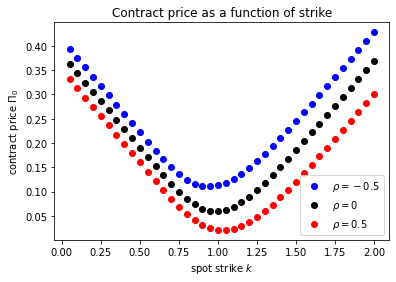

In [ ]:
plt.scatter(K1, pricer_diff_vor_vec(K1,1,rho=-0.5,sig1=0.2,sig2=1,T=1,cache=True), c='b', label=r'$\rho=-0.5$')
plt.scatter(K1, pricer_diff_vor_vec(K1,1,rho=0,sig1=0.2,sig2=1,T=1,cache=True), c='k', label=r'$\rho=0$')
plt.scatter(K1, pricer_diff_vor_vec(K1,1,rho=0.5,sig1=0.2,sig2=1,T=1,cache=True), c='r', label=r'$\rho=0.5$')
plt.xlabel('spot strike $k$')
plt.ylabel('contract price $\Pi_0$')
plt.title('Contract price as a function of strike')
plt.legend(loc='lower right')
plt.show()

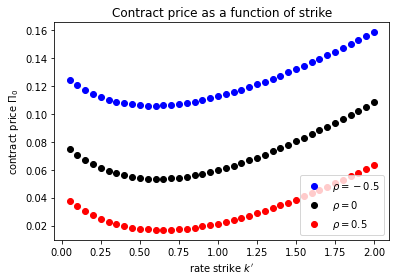

In [ ]:
plt.scatter(K2, pricer_diff_vor_vec(1,K2,rho=-0.5,sig1=0.2,sig2=1,T=1,cache=True), c='b', label=r'$\rho=-0.5$')
plt.scatter(K2, pricer_diff_vor_vec(1,K2,rho=0,sig1=0.2,sig2=1,T=1,cache=True), c='k', label=r'$\rho=0$')
plt.scatter(K2, pricer_diff_vor_vec(1,K2,rho=0.5,sig1=0.2,sig2=1,T=1,cache=True), c='r', label=r'$\rho=0.5$')
plt.xlabel('rate strike $k^\prime$')
plt.ylabel('contract price $\Pi_0$')
plt.title('Contract price as a function of strike')
plt.legend(loc='lower right')
plt.show()

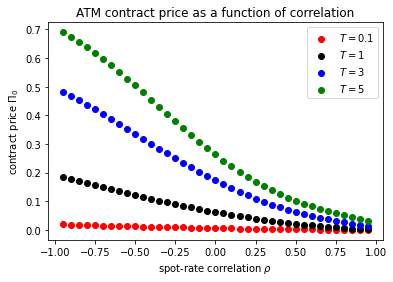

In [ ]:
plt.scatter(Rho, pricer_diff_vor_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=0.1,cache=True), c='r', label='$T=0.1$')
plt.scatter(Rho, pricer_diff_vor_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=1,cache=True), c='k', label='$T=1$')
plt.scatter(Rho, pricer_diff_vor_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=3,cache=True), c='b', label='$T=3$')
plt.scatter(Rho, pricer_diff_vor_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=5,cache=True), c='g', label='$T=5$')
plt.xlabel(r'spot-rate correlation $\rho$')
plt.ylabel('contract price $\Pi_0$')
plt.title('ATM contract price as a function of correlation')
plt.legend()
plt.show()

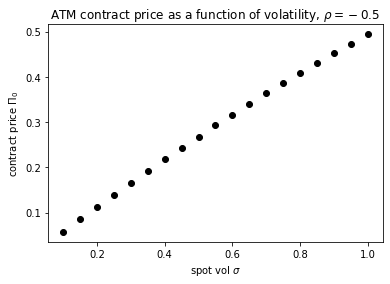

In [ ]:
plt.scatter(Sig1, pricer_diff_vor_vec(1,1,rho=-0.5,sig1=Sig1,sig2=1,T=1,cache=True), c='k')
plt.xlabel('spot vol $\sigma$')
plt.ylabel('contract price $\Pi_0$')
plt.title(r'ATM contract price as a function of volatility, $\rho=-0.5$')
plt.show()

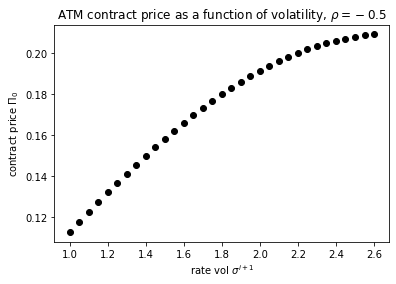

In [ ]:
plt.scatter(Sig2, pricer_diff_vor_vec(1,1,rho=-0.5,sig1=0.2,sig2=Sig2,T=1,cache=True), c='k')
plt.xlabel('rate vol $\sigma^{i+1}$')
plt.ylabel('contract price $\Pi_0$')
plt.title(r'ATM contract price as a function of volatility, $\rho=-0.5$')
plt.show()

In [ ]:
Pi = list()
for rho in tqdm(Rho):
    pi = pricer_diff_vor_vec(k1,k2,rho=rho,sig1=0.2,sig2=1,T=1,cacheAll=True)
    Pi.append(pi)

100%|██████████| 39/39 [02:18<00:00,  3.54s/it]


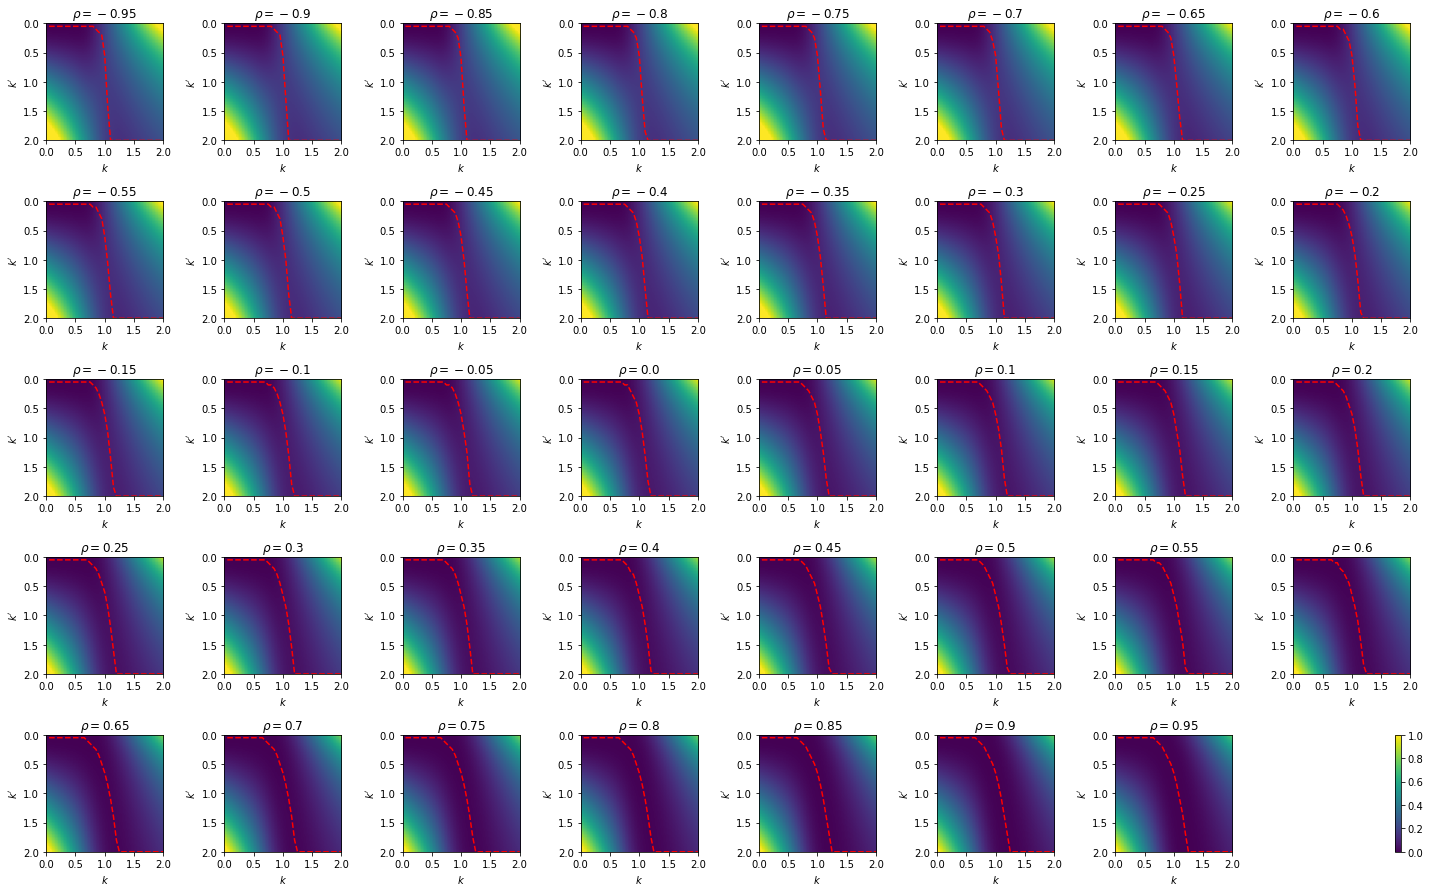

In [ ]:
n = len(Rho)
ncol = 8
ncol = min(n,ncol)
nrow = int(np.ceil(n/ncol))
fig, ax = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2.5*nrow))

for i in range(nrow*ncol):
    ix,iy = i//ncol,i%ncol
    idx = (ix,iy) if nrow>1 else iy
    ax_idx = ax[idx] if ncol>1 else ax
    if i < n:
        im = ax_idx.imshow(Pi[i],extent=[0,2,2,0],vmin=0,vmax=1)
        ax_idx.plot(K1,K2[np.argmin(Pi[i],axis=0)],'r--')
        ax_idx.set_xlabel('$k$')
        ax_idx.set_ylabel('$k^\prime$')
        ax_idx.set_xticks(np.arange(0,2.5,0.5))
        ax_idx.set_yticks(np.arange(0,2.5,0.5))
        ax_idx.set_title(rf'$\rho={np.round(Rho[i],2)}$')
    else:
        ax_idx.axis("off")
fig.colorbar(im)
plt.tight_layout()
plt.show()

## Accuracy of Approximation

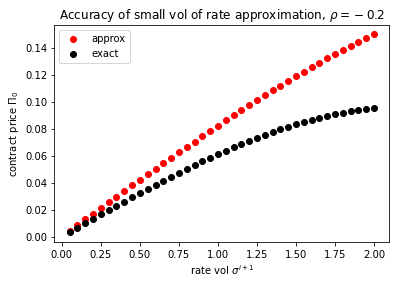

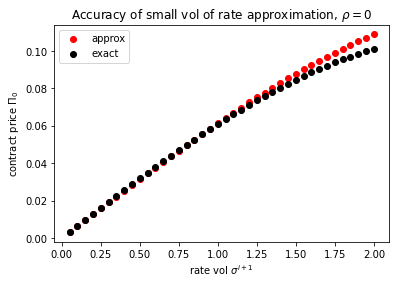

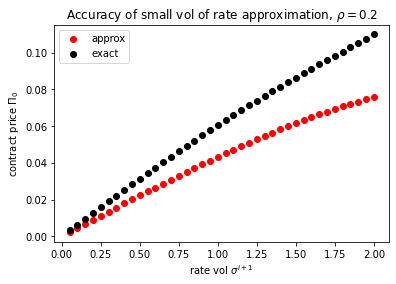

In [ ]:
Sig = np.arange(0.05,2.05,0.05)
for rho in [-0.2,0,0.2]:
    plt.scatter(Sig, pricer_diff_vor_vec(1,1,rho=rho,sig1=0.2,sig2=Sig,T=1,cache=True), c='r', label='approx')
    plt.scatter(Sig, pricer_diff_exact_vec(1,1,rho=rho,sig1=0.2,sig2=Sig,T=1,L0=0.01,disc=False,cache=True), c='k', label='exact')
    plt.xlabel('rate vol $\sigma^{i+1}$')
    plt.ylabel('contract price $\Pi_0$')
    plt.title(rf'Accuracy of small vol of rate approximation, $\rho={rho}$')
    plt.legend()
    plt.show()

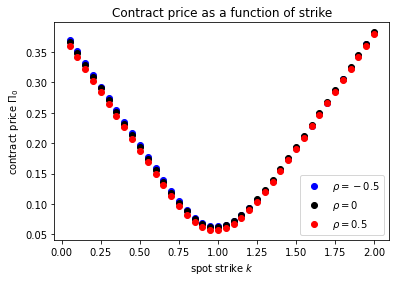

In [ ]:
plt.scatter(K1, pricer_diff_exact_vec(K1,1,rho=-0.5,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cacheAll=True), c='b', label=r'$\rho=-0.5$')
plt.scatter(K1, pricer_diff_exact_vec(K1,1,rho=0,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cacheAll=True), c='k', label=r'$\rho=0$')
plt.scatter(K1, pricer_diff_exact_vec(K1,1,rho=0.5,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cacheAll=True), c='r', label=r'$\rho=0.5$')
plt.xlabel('spot strike $k$')
plt.ylabel('contract price $\Pi_0$')
plt.title('Contract price as a function of strike')
plt.legend(loc='lower right')
plt.show()

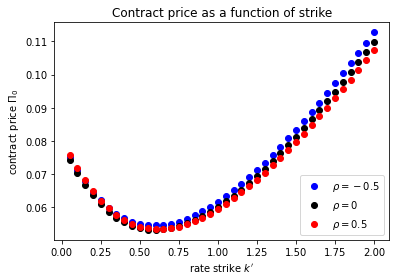

In [ ]:
plt.scatter(K2, pricer_diff_exact_vec(1,K2,rho=-0.5,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cacheAll=True), c='b', label=r'$\rho=-0.5$')
plt.scatter(K2, pricer_diff_exact_vec(1,K2,rho=0,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cacheAll=True), c='k', label=r'$\rho=0$')
plt.scatter(K2, pricer_diff_exact_vec(1,K2,rho=0.5,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cacheAll=True), c='r', label=r'$\rho=0.5$')
plt.xlabel('rate strike $k^\prime$')
plt.ylabel('contract price $\Pi_0$')
plt.title('Contract price as a function of strike')
plt.legend(loc='lower right')
plt.show()

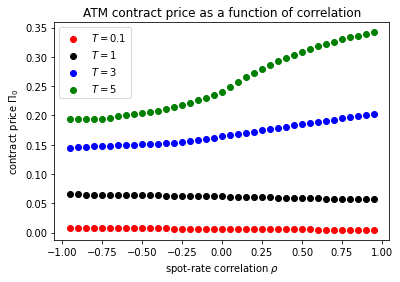

In [ ]:
plt.scatter(Rho, pricer_diff_exact_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=0.1,L0=0.01,disc=False,cache=True), c='r', label='$T=0.1$')
plt.scatter(Rho, pricer_diff_exact_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cache=True), c='k', label='$T=1$')
plt.scatter(Rho, pricer_diff_exact_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=3,L0=0.01,disc=False,cache=True), c='b', label='$T=3$')
plt.scatter(Rho, pricer_diff_exact_vec(1,1,rho=Rho,sig1=0.2,sig2=1,T=5,L0=0.01,disc=False,cache=True), c='g', label='$T=5$')
plt.xlabel(r'spot-rate correlation $\rho$')
plt.ylabel('contract price $\Pi_0$')
plt.title('ATM contract price as a function of correlation')
plt.legend()
plt.show()

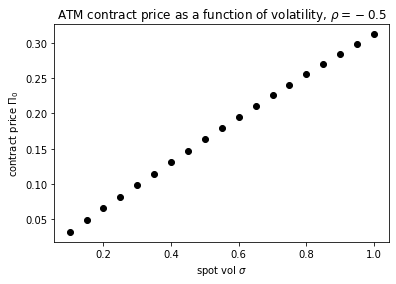

In [ ]:
plt.scatter(Sig1, pricer_diff_exact_vec(1,1,rho=-0.5,sig1=Sig1,sig2=1,T=1,L0=0.01,disc=False,cache=True), c='k')
plt.xlabel('spot vol $\sigma$')
plt.ylabel('contract price $\Pi_0$')
plt.title(r'ATM contract price as a function of volatility, $\rho=-0.5$')
plt.show()

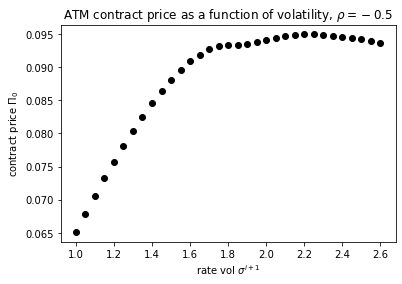

In [ ]:
plt.scatter(Sig2, pricer_diff_exact_vec(1,1,rho=-0.5,sig1=0.2,sig2=Sig2,T=1,L0=0.01,disc=False,cache=True), c='k')
plt.xlabel('rate vol $\sigma^{i+1}$')
plt.ylabel('contract price $\Pi_0$')
plt.title(r'ATM contract price as a function of volatility, $\rho=-0.5$')
plt.show()

In [ ]:
Pi = list()
for rho in tqdm(Rho):
    pi = pricer_diff_exact_vec(k1,k2,rho=rho,sig1=0.2,sig2=1,T=1,L0=0.01,disc=False,cacheAll=True)
    Pi.append(pi)

100%|██████████| 39/39 [00:14<00:00,  2.69it/s]


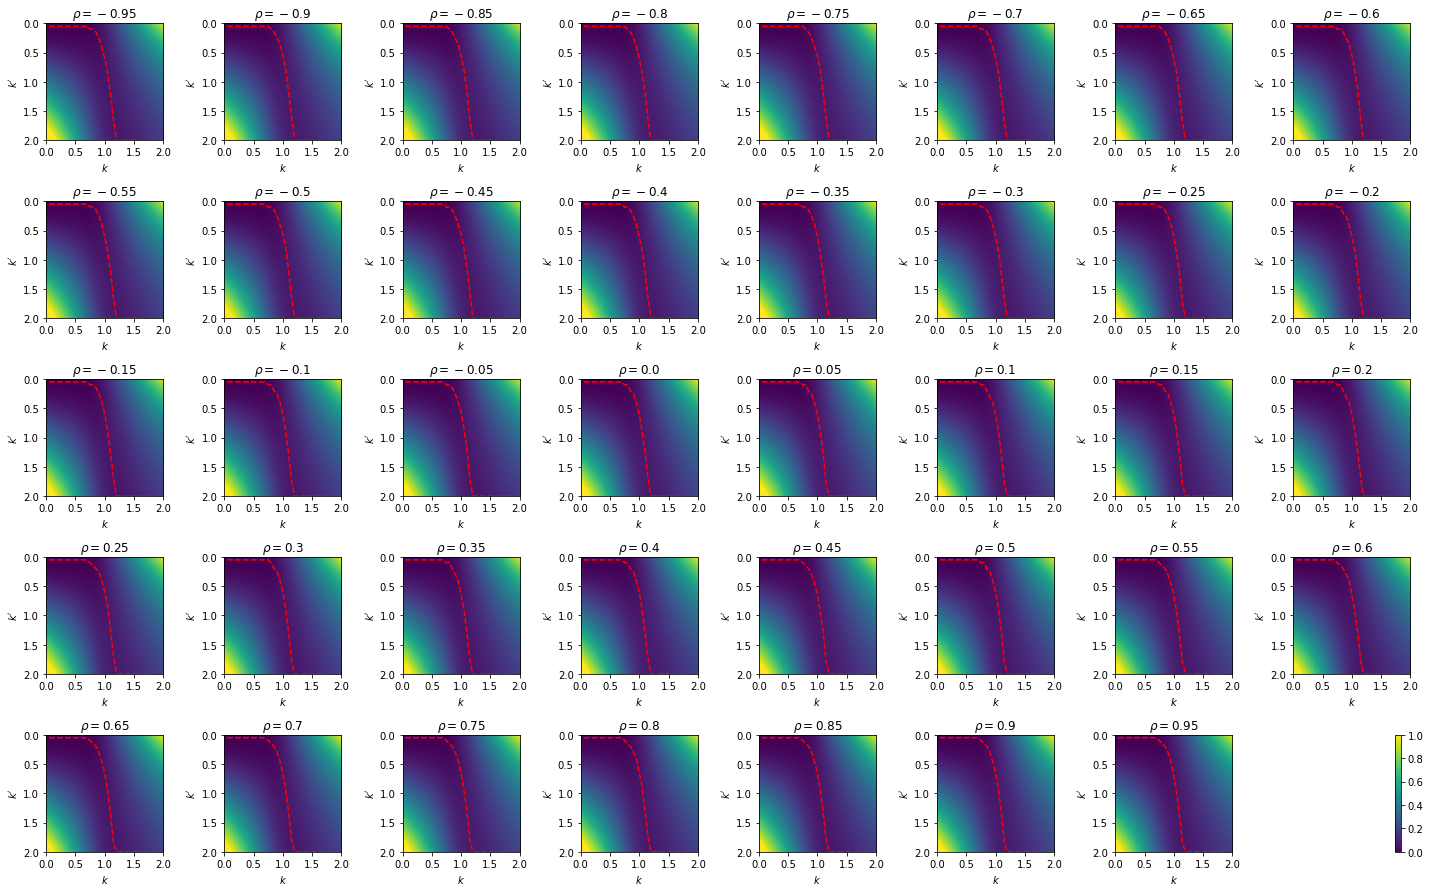

In [ ]:
n = len(Rho)
ncol = 8
ncol = min(n,ncol)
nrow = int(np.ceil(n/ncol))
fig, ax = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2.5*nrow))

for i in range(nrow*ncol):
    ix,iy = i//ncol,i%ncol
    idx = (ix,iy) if nrow>1 else iy
    ax_idx = ax[idx] if ncol>1 else ax
    if i < n:
        im = ax_idx.imshow(Pi[i],extent=[0,2,2,0],vmin=0,vmax=1)
        ax_idx.plot(K1,K2[np.argmin(Pi[i],axis=0)],'r--')
        ax_idx.set_xlabel('$k$')
        ax_idx.set_ylabel('$k^\prime$')
        ax_idx.set_xticks(np.arange(0,2.5,0.5))
        ax_idx.set_yticks(np.arange(0,2.5,0.5))
        ax_idx.set_title(rf'$\rho={np.round(Rho[i],2)}$')
    else:
        ax_idx.axis("off")
fig.colorbar(im)
plt.tight_layout()
plt.show()

## Spot-Rate Density

In [ ]:
_density_diff_cache = dict()

def density_diff(rho, sig1, sig2, T, tau=0.25, L0=0, P0=1, N=1e4, dt=0.004, cache=False):
    '''
    @ rho: spot-rate correlation
    @ sig1: spot vol
    @ sig2: rate vol
    @ T: expiry
    @ tau: arrear interval
    @ L0: LIBOR fwd rate from T to T+tau
    @ P0: bond price expiring T
    @ N: number of simulations
    @ dt: time interval of simulation paths
    @ cache: use cached variables or not
    simulated values of spot/rate for density construction under diffusion model
    '''
    N = int(N)
    M = int(T/dt)

    if cache:
        global _density_diff_cache
        if not _density_diff_cache or \
        (M,N) !=_density_diff_cache['(M,N)']:
            Z = np.random.normal(size=(M,N))
            W = np.random.normal(size=N)
            _density_diff_cache = {
                '(M,N)': (M,N),
                'Z': Z,
                'W': W,
            }
        Z = _density_diff_cache['Z']
        W = _density_diff_cache['W']
    else:
        Z = np.random.normal(size=(M,N))
        W = np.random.normal(size=N)
    Lt = L0*np.cumprod(stoc_exp(sig2,dt,Z),axis=0)
    D = np.exp(-rho*sig2*np.sum(Lt/(1+tau*Lt),axis=0)*dt)
    S = D*stoc_exp(sig1,T,rho*Z[-1]+np.sqrt(1-rho**2)*W)
    L = Lt[-1]/L0
    
    return (S,L)

S,L are martingale
mean of S: 1.005207336614409
mean of L: 0.9976504610031863


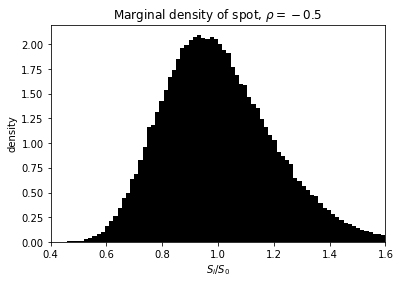

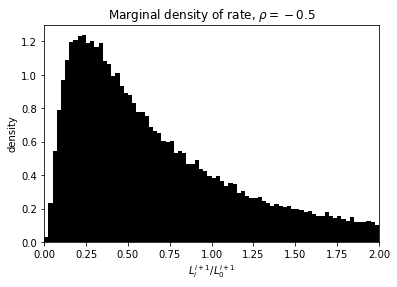

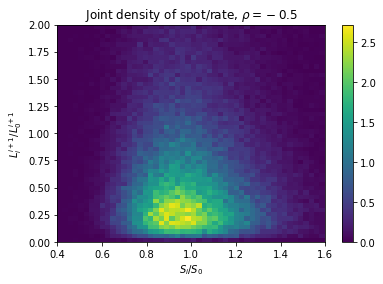

In [ ]:
S,L = density_diff(rho=-0.5,sig1=0.2,sig2=1,T=1,L0=0.01,N=1e5,cache=True)

print('S,L are martingale')
print(f'mean of S: {np.mean(S)}')
print(f'mean of L: {np.mean(L)}')

plt.hist(S,bins=80,range=(0.4,1.6),density=True,color='k')
plt.title(r'Marginal density of spot, $\rho=-0.5$')
plt.xlabel('$S_i/S_0$')
plt.ylabel('density')
plt.xlim([0.4,1.6])
plt.show()

plt.hist(L,bins=80,range=(0,2),density=True,color='k')
plt.title(r'Marginal density of rate, $\rho=-0.5$')
plt.xlabel('$L_i^{i+1}/L_0^{i+1}$')
plt.ylabel('density')
plt.xlim([0,2])
plt.show()

plt.hist2d(S,L,bins=50,range=((0.4,1.6),(0,2)),density=True)
plt.title(r'Joint density of spot/rate, $\rho=-0.5$')
plt.xlabel('$S_i/S_0$')
plt.ylabel('$L_i^{i+1}/L_0^{i+1}$')
plt.colorbar()
plt.show()

in-the-money probability: 0.49678
ATM contract value: 0.0639296021581117


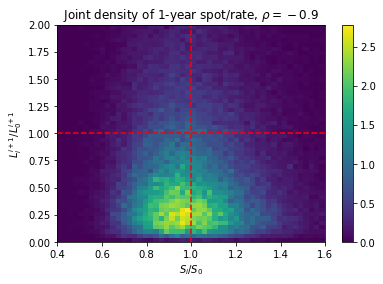

in-the-money probability: 0.48517
ATM contract value: 0.06100379313991727


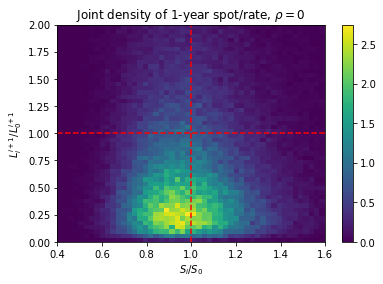

in-the-money probability: 0.4708
ATM contract value: 0.05848273580350057


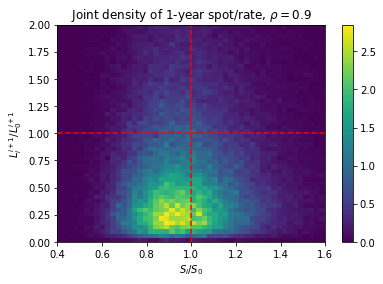

In [ ]:
for rho in [-0.9,0,0.9]:
    S,L = density_diff(rho=rho,sig1=0.2,sig2=1,T=1,L0=0.01,N=1e5,cache=True)
    print('in-the-money probability:', sum(((S<1)&(L>1))|((S>1)&(L<1)))/len(S))
    print('ATM contract value:', np.mean(np.maximum((S-1)*(1-L),0)))
    plt.hist2d(S,L,bins=50,range=((0.4,1.6),(0,2)),density=True)
    plt.axvline(x=1,c='r',ls='--')
    plt.axhline(y=1,c='r',ls='--')
    plt.title(rf'Joint density of 1-year spot/rate, $\rho={rho}$')
    plt.xlabel('$S_i/S_0$')
    plt.ylabel('$L_i^{i+1}/L_0^{i+1}$')
    plt.colorbar()
    plt.show()

in-the-money probability: 0.46688
ATM contract value: 0.14737196350850457


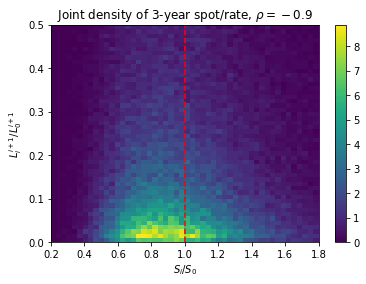

in-the-money probability: 0.45869
ATM contract value: 0.1675120870113301


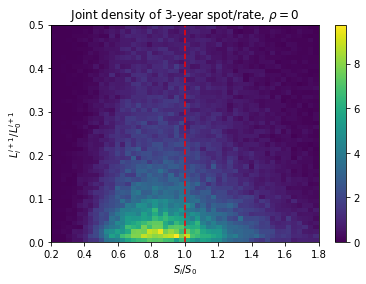

in-the-money probability: 0.45169
ATM contract value: 0.20632019242172206


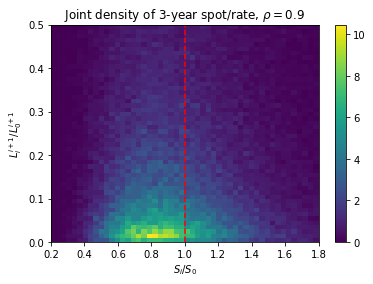

In [ ]:
for rho in [-0.9,0,0.9]:
    S,L = density_diff(rho=rho,sig1=0.2,sig2=1,T=3,L0=0.01,N=1e5,cache=True)
    print('in-the-money probability:', sum(((S<1)&(L>1))|((S>1)&(L<1)))/len(S))
    print('ATM contract value:', np.mean(np.maximum((S-1)*(1-L),0)))
    plt.hist2d(S,L,bins=50,range=((0.2,1.8),(0,0.5)),density=True)
    plt.axvline(x=1,c='r',ls='--')
    plt.axhline(y=1,c='r',ls='--')
    plt.title(rf'Joint density of 3-year spot/rate, $\rho={rho}$')
    plt.xlabel('$S_i/S_0$')
    plt.ylabel('$L_i^{i+1}/L_0^{i+1}$')
    plt.colorbar()
    plt.show()

# Short-Rate Model

## Calibration of Heston

In [ ]:
!pip install nelson-siegel-svensson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.7 MB/s 
     |████████████████████████████████| 11.2 MB 47.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [ ]:
def charifunc(phi, rho, lbd, t, r, S0, v0, k, theta, sigma):
    
    a = k*theta
    b = k+lbd
    rpi = rho*sigma*phi*1j
    c = np.sqrt((rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2)
    d = (b-rpi+c)/(b-rpi-c)
    
    return np.exp(r*phi*1j*t) * S0**(phi*1j) * ((1-d*np.exp(c*t))/(1-d))**(-2*a/sigma**2) * np.exp(a*t*(b-rpi+c)/sigma**2 + v0*(b-rpi+c)*((1-np.exp(c*t))/(1-d*np.exp(c*t)))/sigma**2)
    
def heston_price(S0, K, v, k, theta, sigma, rho, lbd, t, r):
    args = (rho, lbd, t, r, S0, v, k, theta, sigma)
    price = 0
    up_limit_ = 100
    n = 10000
    dt = up_limit_/n

    for i in range(1,n):
        phi = dt * (2*i + 1)/2
        numerator = np.exp(r*t)*charifunc(phi-1j,*args) - K * charifunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        price += dt * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*t))/2 + price/np.pi)


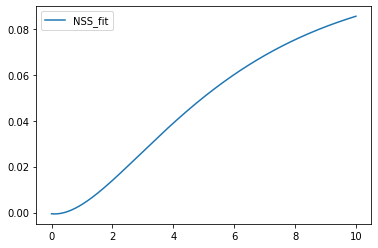

In [ ]:
## Get the parameteric yield curve from Nelson Siegel Svensson model 
## We use JPY Libor rate to approximate risk-free interest rate
yield_maturities = np.array([1/12, 3/12, 6/12])
yields = np.array([-0.06005,-0.04713,0.03097]).astype(float)/100
curve_fit, status = calibrate_nss_ols(yield_maturities,yields) 

y = curve_fit
t = np.linspace(0, 10, 10000)

## Plot the yield curve
plt.plot(t, y(t),label = 'NSS_fit')
plt.legend()
plt.show()

In [ ]:
from scipy.linalg.special_matrices import dft
from locale import D_FMT
## Get the NIKKEI 225 call option data from Bloomberg 
## Read the data from the drive
from google.colab import drive 
import pandas as pd
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/MyDrive/NKY.csv')
df['rate'] = df['maturity'].apply(curve_fit)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Get the settlement call price for Nikkei option
## Get the settlement spot price of Nikkei 225 as spot price
S0 = df['spot'].to_numpy('float')
r = df['rate'].to_numpy('float')
K = df['Strike'].to_numpy('float')
t = df['maturity'].to_numpy('float')
MP = df['Price'].to_numpy('float')

## Implement min_squared_error to get the parameters
cali_vars = {"v": {"x0": 0.05, "bnd": [1e-3,0.5]}, 
          "k": {"x0": 1.5, "bnd": [1e-3,2]},
          "theta": {"x0": 0.05, "bnd": [1e-3,0.5]},
          "sigma": {"x0": 0.5, "bnd": [1e-2,1]},
          "rho": {"x0": -0.5, "bnd": [-1,1]},
          "lbd": {"x0": 0.5, "bnd": [-1,1]}}

x0 = [cali_var["x0"] for key, cali_var in cali_vars.items()]
bnds = [cali_var["bnd"] for key, cali_var in cali_vars.items()]

def Squared_err(x):
    v, k, theta, sigma, rho, lbd = [cali_var for cali_var in x]
    err = np.sum((MP-heston_price(S0, K, v, k, theta, sigma, rho, lbd, t, r))**2 /len(P))
    return err

result = minimize(Squared_err, x0, tol = 1e-4, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)
v, k, theta, sigma, rho, lbd = [cali_var for cali_var in result.x]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [ ]:
print(result)

     fun: 0.15970195794123446
     jac: array([ 1.40493134e+02,  9.30800661e-03,  3.71038651e+01, -1.71518382e+00,
        7.83258528e+00, -8.34635004e-01])
 message: 'Optimization terminated successfully'
    nfev: 55
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 0.03993293,  1.69993713,  0.04011673,  0.49977804, -0.70141614,
        0.40182189])


In [ ]:
price = heston_price(S0, K, v, k, theta, sigma, rho, lbd, t, r)
df['mod'] = price

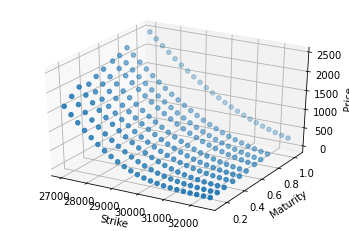

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zdata = df['mod']
xdata = df['Strike']
ydata = df['maturity']
ax.scatter3D(xdata, ydata, zdata, 'green')
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
plt.show()

## Calibration of Hull-White

In [ ]:
## We use United States Treasury Strip Coupon Price (Zero Coupon Bond) to calibrate HUll White Model 
## Data is pulled from Bloomberg 
from scipy.linalg.special_matrices import dft
from locale import D_FMT
## Read the data from the drive
from google.colab import drive 
import pandas as pd
drive.mount('/content/gdrive')
bp = pd.read_excel('gdrive/MyDrive/US_Zero.xlsx')

df = pd.DataFrame(index = bp.index)

df['price'] = bp['Ask Price']
df['Maturity'] = (pd.to_datetime(bp['Maturity']) - pd.to_datetime('2022-11-23')).dt.days / 365
df = df[df['Maturity'] < 10]
T = df['Maturity'].to_numpy('float')
P = df['price'].to_numpy('float') / 100

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


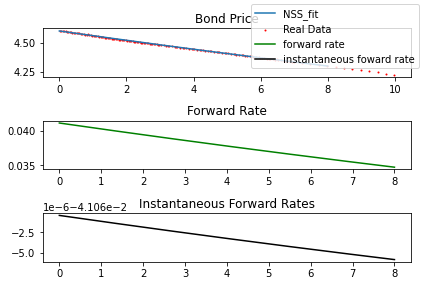

In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.misc import derivative
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
import numpy as np
## Fit the bond price curve
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, df['Maturity'], np.log(df['price']))

#curve_fit, status = calibrate_nss_ols(np.array(df['Maturity']),np.array(np.log(df['price'])))
def function(x):
    y = func(x,*popt)
    return y

def deriv(x):
    return derivative(function, x)

y = curve_fit
t = np.linspace(0, 8, 10000)

figure, axis = plt.subplots(3, 1)
## For P(0,T)
axis[0].plot(t, func(t, *popt),label = 'NSS_fit')
axis[0].scatter(df['Maturity'],np.log(df['price']), c='red',s = 1,label = 'Real Data')
axis[0].set_title("Bond Price")

# For forward rate curve
axis[1].plot(t, -deriv(t), color='green', label='forward rate')
axis[1].set_title("Forward Rate")


# For market-implied instantaneous forward rates
axis[2].plot(t, deriv(-deriv(t)), color='black', label='instantaneous foward rate')
axis[2].set_title("Instantaneous Forward Rates")

figure.tight_layout()
figure.legend()
plt.show()

In [ ]:
from scipy.integrate import quad

def theta_cal(T,a,sigma):
    return deriv(-deriv(T)) + a * (-deriv(T)) + sigma**2 / (2*a) * (1-np.exp(-2*a*T))

def integrand(x, T,a, sigma):
    B = (1- np.exp(-a*x))/a
    theta = deriv(-deriv(x)) + a * (-deriv(x)) + sigma**2 / (2*a) * (1-np.exp(-2*a*x))

    return theta * B

def bond_price(T,a,sigma,r):
    B = (1- np.exp(-a*T))/a
    I, error = quad(integrand, 0, T, args=(T,a,sigma))
    A = (np.exp(-I) - (sigma**2 / (2*(a**2)))) * (B - T) - (sigma**2)/(4*a) * B**2
    price = np.exp(A - B*r)
    return price

params = params = {"a": {"x0": 2, "bnd": [0.001,5]}, 
          "sigma": {"x0": 0.02, "bnd": [0.001,1]},
          "r_0": {"x0": 0.02, "bnd": [0.001,1]}}

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["bnd"] for key, param in params.items()]

def Squared_err(x):
    a, sigma, r_0= [param for param in x]
    err = 0
    for i in range(len(P)):
        err += ((P[i]-bond_price(T[i],a, sigma, r_0))**2 /len(P))
   
    return err

result = minimize(Squared_err, x0, tol = 1e-4, method='SLSQP', options={'maxiter': 1e3 }, bounds=bnds)
a, sigma, r_0 = [param for param in result.x]
print(result)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


     fun: 0.00014846782427135107
     jac: array([0.07987581, 0.0063245 , 0.02147925])
 message: 'Optimization terminated successfully'
    nfev: 89
     nit: 20
    njev: 19
  status: 0
 success: True
       x: array([0.00880248, 0.06907028, 0.03235033])


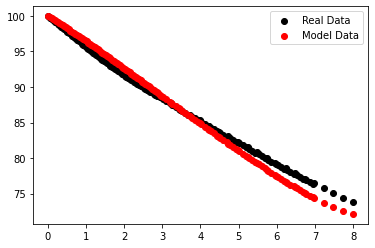

In [ ]:
bp_lst = []
for i in range(len(df)):
    bp_lst.append(bond_price(T[i],a, sigma,r_0) * 100)
df['mod'] = bp_lst
plt.scatter(df['Maturity'],df['price'],color = 'black',label = 'Real Data')
plt.scatter(df['Maturity'],df['mod'],color = 'red',label = 'Model Data')
plt.legend()
plt.show()

## Monte-Carlo Simulation

In [ ]:
## Fit the bond price curve
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

#curve_fit, status = calibrate_nss_ols(np.array(df['Maturity']),np.array(np.log(df['price'])))
def function(x):
    y = func(x,*popt)
    return y

def deriv(x):
    return derivative(function, x)

## Simulation for short rate 
def theta_cal(T,a,sigma):
  return deriv(-deriv(T)) + a * (-deriv(T)) + sigma**2 / (2*a) * (1-np.exp(-2*a*T))

def simulation(strike,strike_prime,T = 3,delta = 0.25,sigma_r = 0.06907028,sigma_S = 0.49977804):
  dt = 1/252 ## One banking date 
  N = 10000 ## Number of simulation
  #T = 3
  #delta = 0.25

  ## Parameters from calibration in Hull-White
  r_0 = 0.03235033
  a = 0.00880248
  #sigma_r = 0.06907028
  p_tT, p_0t, p_0T = 0,0,0

  ## Parameters from calibration in Heston
  v_0, k, theta, rho, lbd = 0.03993293, 1.69993713, 0.04011673,  -0.70141614, 0.40182189
  S_0 = 28162.83 ## Closed price of Nikkei 225 Index at 11/25
  k_Q = k + lbd
  theta_Q = (k * theta) / (k + lbd)
  rf = -0.001 ## Japan 1 Year Government Bond Interest Rate 


  ## Simulate for Bond price 
  r = np.zeros((int(N/100),int((T+delta)/dt)+1,N)) ## Initialize short rate matrix
  r[:,0,:] += r_0
  
  for j in range(1,int((T+delta)/dt)+1):
      eps_r = np.random.normal(0,1,(int(N/100),N))
      ## Simulate short rate
      r[:,j,:] = r[:,j-1,:] + (theta_cal(j*dt,a,sigma_r) - a*r[:,j-1,:]) * dt + sigma_r * np.sqrt(dt) * eps_r
  p_tT = np.mean(np.exp(-1 * (np.sum(r[:,int(T/dt):],axis = 1))*dt),axis = 0)
  p_0t = np.mean(np.exp(-1 * (np.sum(r[:,:int(T/dt)+1],axis = 1))*dt),axis = 0)
  p_0T = np.mean(np.exp(-1 * (np.sum(r,axis = 1))*dt),axis = 0)
  
  ## Simulate libor rate
  L_tt = (1-p_tT) / (delta * p_tT)
  L_0t = (p_0t - p_0T) / (delta * p_0T)
  
  ## Simulate stock price

  v = np.full(N,v_0)
  S = np.full(N,S_0)
 
  for j in range(1,int((T+delta)/dt)+1):
    
    eps_v = np.random.normal(0,1,N)
    eps = np.random.normal(0,1,N)
    eps_S = rho * eps_v + np.sqrt(1-rho**2 ) * eps
    S = S * np.exp((rf - 1/2 * v)*dt + np.sqrt(v * dt) * eps_S)
    v = v + k_Q*(theta_Q - v) * dt + sigma_S * np.sqrt(v * dt) * eps_v
    v[v < 0] = 0 ## Full Truncate Scheme
    
    
  ## Simulate option price
  C = (S/S_0-strike) * (strike_prime - L_tt/L_0t)
  C[C < 0] = 0
  
  return  round(np.mean(C),2)


In [ ]:
K1 = np.arange(0.05,2.05,0.05)
K2 = [0.5,0.75,1.01,1.25,1.5]
df = {'k':[],'k_prime':[], 'price':[]}
for k1 in K1:
  for k2 in K2:
    df['k'].append(k1)
    df['k_prime'].append(k2)
    df['price'].append(simulation(k1,k2))
    
df = pd.DataFrame(df)

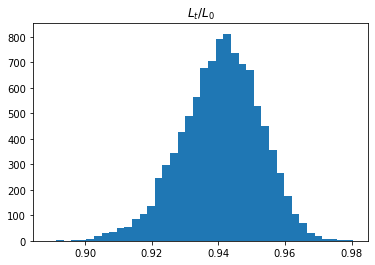

In [ ]:
plt.title("$L_t/L_0$")
plt.hist(L,bins=40)
plt.show()

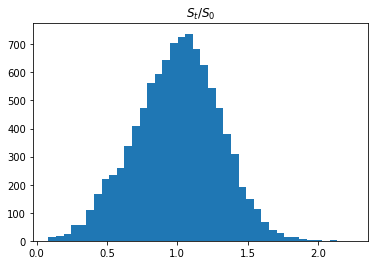

In [ ]:
plt.title("$S_t/S_0$")
plt.hist(S/S_0,bins=40)
plt.show()

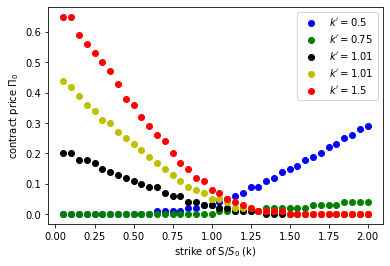

In [ ]:
plt.scatter(K1, df[df['k_prime'] == 0.5]['price'], c='b', label=r'$k^\prime= 0.5$')
plt.scatter(K1, df[df['k_prime'] == 0.75]['price'], c='g', label=r'$k^\prime= 0.75$')
plt.scatter(K1, df[df['k_prime'] == 1.01]['price'], c='k', label=r'$k^\prime= 1.01$')
plt.scatter(K1, df[df['k_prime'] == 1.25]['price'], c='y', label=r'$k^\prime= 1.01$')
plt.scatter(K1, df[df['k_prime'] == 1.5]['price'], c='r', label=r'$k^\prime= 1.5$')
plt.xlabel('strike of S/$S_0$ (k)')
plt.ylabel('contract price $\Pi_0$')
plt.legend()
plt.show()

In [ ]:
K1 = [0.4,0.6,0.9,1.2,1.4]
K2 = np.arange(0.05,2.05,0.05)
df1 = {'k':[],'k_prime':[], 'price':[]}
for k1 in K1:
  for k2 in K2:
    print(k1,k2)
    df1['k'].append(k1)
    df1['k_prime'].append(k2)
    df1['price'].append(simulation(k1,k2))
df1 = pd.DataFrame(df1)

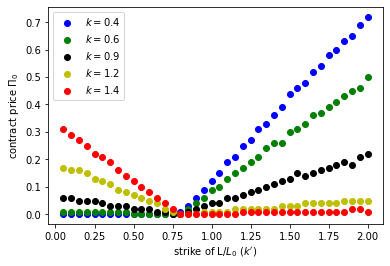

In [ ]:
plt.scatter(K2, df1[df1['k'] == 0.4]['price'], c='b', label=r'$k = 0.4$')
plt.scatter(K2, df1[df1['k'] == 0.6]['price'], c='g', label=r'$k = 0.6$')
plt.scatter(K2, df1[df1['k'] == 0.9]['price'], c='k', label=r'$k = 0.9$')
plt.scatter(K2, df1[df1['k'] == 1.2]['price'], c='y', label=r'$k = 1.2$')
plt.scatter(K2, df1[df1['k'] == 1.4]['price'], c='r', label=r'$k = 1.4$')
plt.xlabel('strike of L/$L_0$ ($k^\prime$)')
plt.ylabel('contract price $\Pi_0$')
plt.legend()
plt.show()

## Parameter Sensitivity

In [ ]:
K1 = np.arange(0.05,2.05,0.05)
K2 = np.arange(0.05,2.05,0.05)
df2 = {'k':[],'k_prime':[], 'price':[]}
for k1 in K1:
  for k2 in K2:
    print(k1,k2)
    df2['k'].append(k1)
    df2['k_prime'].append(k2)
    df2['price'].append(simulation(k1,k2))
df2 = pd.DataFrame(df2)

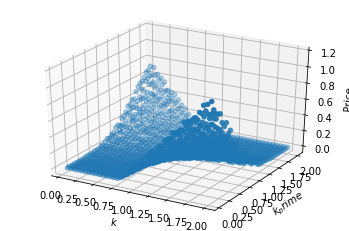

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zdata = df2['price']
xdata = df2['k_prime']#df2['k']
ydata = df2['k']
ax.scatter3D(xdata, ydata, zdata, 'green')
ax.set_xlabel('$k$')
ax.set_ylabel('$k_prime$')
ax.set_zlabel('Price')
plt.show()

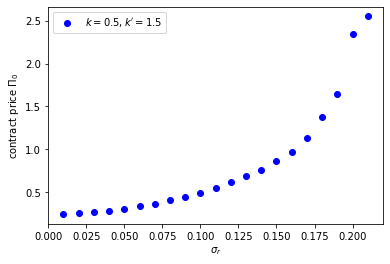

In [ ]:
Sig1 = np.arange(0.01,0.25,0.01)
df2 = {'sig':[], 'price':[]}
for sig in Sig1:
  print(sig)
  df2['sig'].append(sig)
  df2['price'].append(simulation(strike = 0.5,strike_prime = 1.5,sigma_r = sig))
df2 = pd.DataFrame(df2)
plt.scatter(df2['sig'], df2['price'], c='b', label=r'$k = 0.5, k^{\prime} = 1.5$')
plt.xlabel('$\sigma_r}$')
plt.ylabel('contract price $\Pi_0$')
plt.legend()
plt.show()